# qMC integration on a $d$-simplex

The `Sort` and `Root` transformations $\mathbf{x}\rightarrow\mathbf{u}$, $\mathbf{x}\in[0,1]^d, \mathbf{u}\in T_d$ studied here are defined in

    Tim Pillards, Ronald Cools
    "Transforming low-discrepancy sequences from a cube to a simplex"
    Journal of Computational and Applied Mathematics
    Volume 174, Issue 1, 2005, Pages 29-42
    
https://doi.org/10.1016/j.cam.2004.03.019

There are a few more transformations described in that paper, which do not fit our needs.

- `Drop` discards sequence points, retains only $N / d!$ out of $N$ points.
- `Mirror` is discontinuous.
- `Origami` becomes exponentially hard for large $d$.
- `Shift` is not defined for $d > 2$.

In [31]:
using PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

In [32]:
using QInchworm.ScrambledSobol: ScrambledSobolSeq, next!

"""
    Volume of a d-dimensional simplex.
"""
simplex_vol(d::Int) = 1 / factorial(d);

"""
    Quasi Monte Carlo integration on a d-dimensional simplex.

    `f`        Integrand.
    `d`        Dimension of the problem.
    `trans`    Transformation from a d-dimensional unit cube to the simplex.
    `jacobian` Jacobian of the transformation.
    `seq`      Sobol low-discrepancy-sequence.
    `N`        Number of samples.
"""
function qMCIntegrateInSimplex(f, d::Int, trans, jacobian, seq::ScrambledSobolSeq, N::Int)
    s = 0
    for i = 1:N
        x = next!(seq)
        u = trans(x)
        if u[1] < 0 || u[end] > 1
            continue
        end
        s += f(u) * jacobian(u)
    end
    s / N
end;

## `Sort` transformation of a $d$-dimensional unit cube

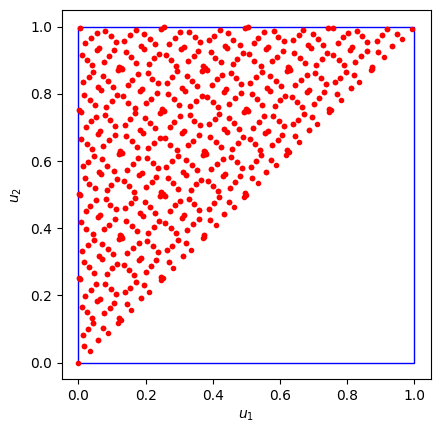

In [33]:
seq = ScrambledSobolSeq(2)

p = reduce(hcat, sort(next!(seq)) for i = 1:1024)'
plt.subplot(111, aspect = "equal")
plt.plot(p[:,1], p[:,2], "r.")
plt.gca().add_patch(plt.matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="b", facecolor="none"))
plt.xlabel(raw"$u_1$");
plt.ylabel(raw"$u_2$");

## `Root` transformation of a $d$-dimensional unit cube

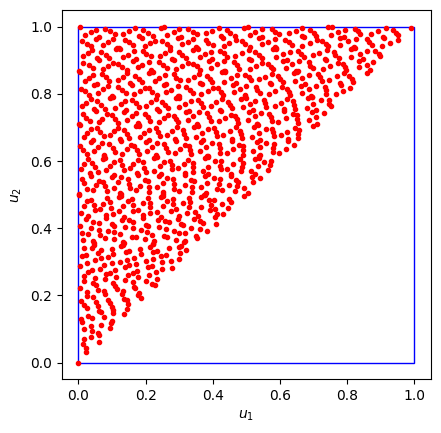

In [34]:
"""
    Make a Root transformation from a d-dimensional unit cube to the simplex.
"""
function make_trans_root(d::Int)
    x -> begin
        u = Vector{Float64}(undef, d)
        u[d] = x[d] ^ (1.0/d)
        for s = d-1:-1:1
            u[s] = u[s + 1] * (x[s] ^ (1.0 / s))
        end
        return u
    end
end;

seq = ScrambledSobolSeq(2)
trans = make_trans_root(2)

p = reduce(hcat, trans(next!(seq)) for i = 1:1024)'
plt.subplot(111, aspect = "equal")
plt.plot(p[:,1], p[:,2], "r.")
plt.gca().add_patch(plt.matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="b", facecolor="none"))
plt.xlabel(raw"$u_1$");
plt.ylabel(raw"$u_2$");

## `ExpDiff` transformation of a $d$-dimensional unit cube

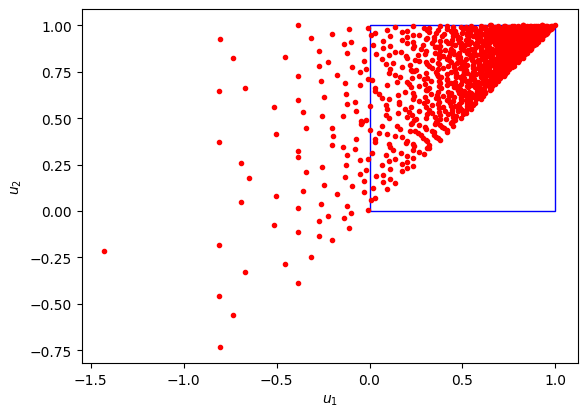

In [35]:
"""
    Make an ExpDiff transformation x -> u such that x ∈ [0,1]^d and -∞ < u_1 ≤ u_2 ≤ ... ≤ u_d ≤ 1.

    `τ` Parameter of the exponential decay function.
"""
function make_trans_expdiff(d::Int, τ::Real)
    x -> begin
        u = Vector{Float64}(undef, length(x))
        u[d] = 1 + τ*log(1 - x[d])
        for i = d-1:-1:1
            u[i] = u[i+1] + τ*log(1 - x[i])
        end
        u
    end
end

"""
    Make Jacobian of the ExpDiff transformation.
"""
function make_jacobian_expdiff(d::Int, τ::Real)
    u -> τ^d / exp(-(1 - u[1]) / τ)
end

seq = ScrambledSobolSeq(2)
trans = make_trans_expdiff(2, 0.25)

p = reduce(hcat, trans(next!(seq)) for i = 1:1024)'
plt.subplot(111, aspect = "equal")
plt.gca().add_patch(plt.matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="b", facecolor="none"))
plt.plot(p[:,1], p[:,2], "r.")
plt.xlabel(raw"$u_1$");
plt.ylabel(raw"$u_2$");

## Scan a range of sample numbers $N$

In [36]:
function scan_N_range(f, d::Int, trans, jacobian, N_list::Vector{Int}; verbose = false)
    N_steps = [N_list[1]]
    append!(N_steps, diff(N_list))
    chunks = zeros(Float64, length(N_steps))
    
    seq = ScrambledSobolSeq(d)
    N = 0
    for (i, N_step) in Iterators.enumerate(N_steps)
        chunks[i] = qMCIntegrateInSimplex(f, d, trans, jacobian, seq, N_step) * N_step
        if verbose
            println("Chunk $i: Sobol sequence points [$N; $(N + N_step)[: contribution = $(chunks[i])")
            flush(stdout)
        end
        N += N_step
    end
    results = cumsum(chunks)
    for i = 1:length(N_steps)
        results[i] /= N_list[i]
    end
    results
end

function plot_N_convergence(N_list, div_list, label_list, pdf_filename; title = nothing)
    if !isnothing(title)
        plt.suptitle(title)
    end
    
    y_min, y_max = Inf, -Inf
    for (div, label) in Iterators.zip(div_list, label_list)
        y = abs.(div)
        plt.loglog(N_list, y, lw=2.0, marker="o", label = label)
        y_min = min(y_min, minimum(y))
        y_max = max(y_max, maximum(y))
        for i = -5:5
            plt.loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
            plt.loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
        end
    end

    plt.xlabel(raw"$N$")
    plt.ylabel(raw"$|I - I_{ref}|$")
    plt.xlim(N_list[1], N_list[end])
    plt.ylim(y_min, y_max)
    plt.legend(loc = "best")
    
    plt.savefig(pdf_filename)
end

plot_N_convergence (generic function with 1 method)

## $d = 1$

  2.963352 seconds (50.45 M allocations: 3.006 GiB, 13.88% gc time, 3.55% compilation time: 8% of which was recompilation)
  2.946175 seconds (50.36 M allocations: 3.002 GiB, 8.63% gc time, 0.70% compilation time)
  3.201898 seconds (48.10 M allocations: 2.867 GiB, 6.57% gc time, 0.97% compilation time)


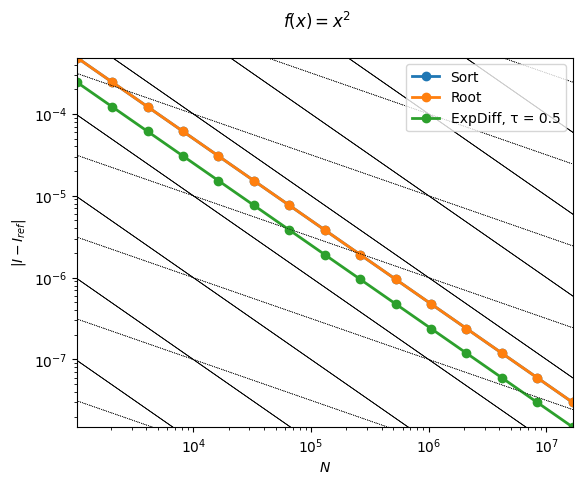

In [37]:
d = 1

τ = 0.5
N_list = round.(Int, exp2.(range(10, 24, length=15)))

f = x -> sum(x.^2)
ref = 1/3

@time results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_list)
@time results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_list)
@time results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_x2_1d.pdf",
                    title = raw"$f(x) = x^2$")

  4.304442 seconds (67.15 M allocations: 4.002 GiB, 8.18% gc time, 0.88% compilation time)
  4.233577 seconds (67.14 M allocations: 4.002 GiB, 8.05% gc time, 0.50% compilation time)
  3.929602 seconds (62.60 M allocations: 3.731 GiB, 6.46% gc time, 0.58% compilation time)


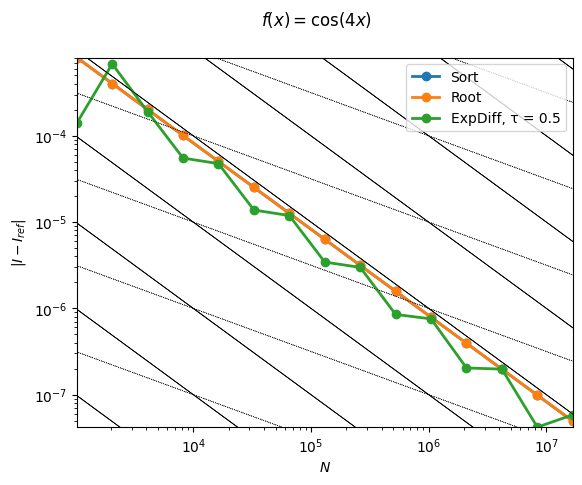

In [38]:
d = 1

τ = 0.5
N_list = round.(Int, exp2.(range(10, 24, length=15)))

f = x -> sum(cos.(4x))
ref = sin(4) / 4

@time results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_list)
@time results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_list)
@time results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_cos4x_1d.pdf",
                   title = raw"$f(x) = \cos(4x)$")

## $d = 2$

  3.588971 seconds (50.37 M allocations: 3.752 GiB, 9.96% gc time, 1.25% compilation time)
  4.047938 seconds (50.36 M allocations: 3.752 GiB, 8.86% gc time, 0.55% compilation time)
  3.553726 seconds (43.55 M allocations: 3.244 GiB, 8.87% gc time, 0.68% compilation time)


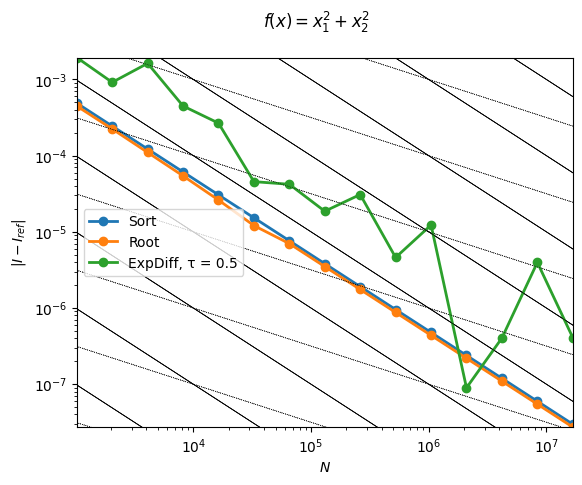

In [39]:
d = 2

τ = 0.5
N_list = round.(Int, exp2.(range(10, 24, length=15)))

f = x -> sum(x.^2)
ref = 1/3

@time results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_list)
@time results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_list)
@time results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_x2_2d.pdf",
                   title = raw"$f(x) = x_1^2 + x_2^2$")

  4.952249 seconds (67.15 M allocations: 5.002 GiB, 9.57% gc time, 0.74% compilation time)
  5.487000 seconds (67.14 M allocations: 5.002 GiB, 8.93% gc time, 0.39% compilation time)
  4.337951 seconds (53.51 M allocations: 3.987 GiB, 8.81% gc time, 0.59% compilation time)


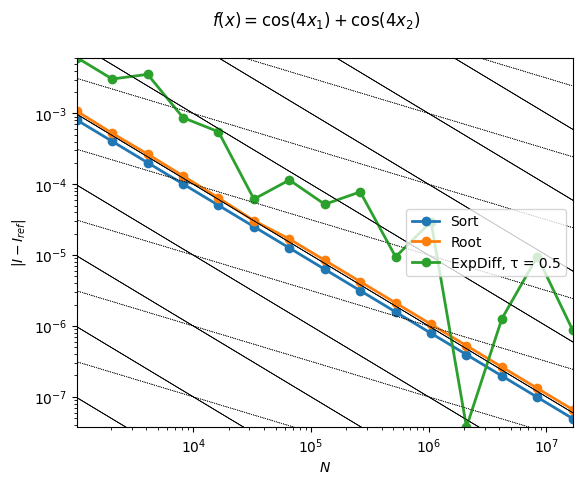

In [40]:
d = 2

τ = 0.5
N_list = round.(Int, exp2.(range(10, 24, length=15)))

f = x -> sum(cos.(4x))
ref = sin(4) / 4

@time results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_list)
@time results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_list)
@time results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_cos4x_2d.pdf",
                   title = raw"$f(x) = \cos(4x_1) + \cos(4x_2)$")

## $d = 3$

  3.828964 seconds (50.43 M allocations: 3.755 GiB, 9.70% gc time, 2.36% compilation time)
  4.647646 seconds (50.36 M allocations: 3.752 GiB, 7.78% gc time, 0.40% compilation time)
  3.364659 seconds (39.01 M allocations: 2.906 GiB, 8.64% gc time, 0.76% compilation time)


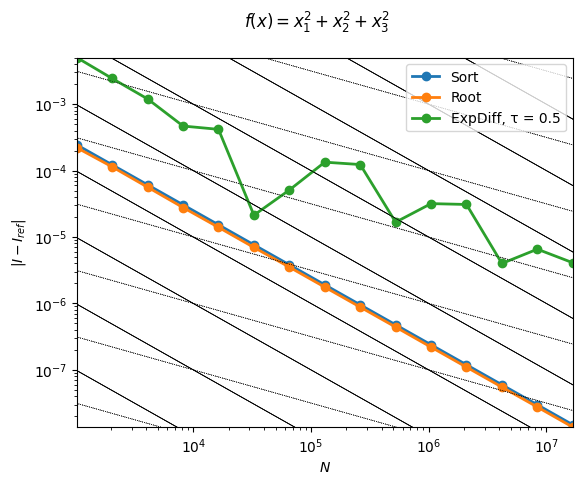

In [41]:
d = 3

τ = 0.5
N_list = round.(Int, exp2.(range(10, 24, length=15)))
 
f = x -> sum(x.^2)
ref = 1/6

@time results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_list)
@time results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_list)
@time results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_x2_3d.pdf",
                   title = raw"$f(x) = x_1^2 + x_2^2 + x_3^2$")

  5.482742 seconds (67.15 M allocations: 5.002 GiB, 8.86% gc time, 0.62% compilation time)
  6.464271 seconds (67.14 M allocations: 5.002 GiB, 7.58% gc time, 0.30% compilation time)
  3.916391 seconds (44.43 M allocations: 3.310 GiB, 8.00% gc time, 0.62% compilation time)


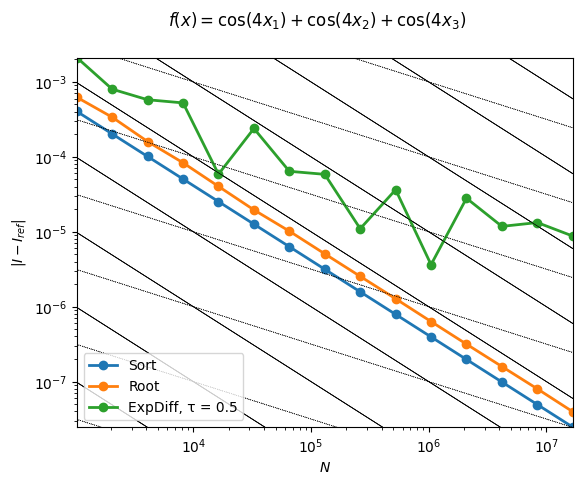

In [42]:
d = 3

τ = 0.5
N_list = round.(Int, exp2.(range(10, 24, length=15)))

f = x -> sum(cos.(4x))
ref = sin(4) / 8

@time results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_list)
@time results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_list)
@time results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_cos4x_3d.pdf",
                   title = raw"$f(x) = \cos(4x_1) + \cos(4x_2) + \cos(4x_3)$")

## `ExpDiff` transformation at various values of $\tau$

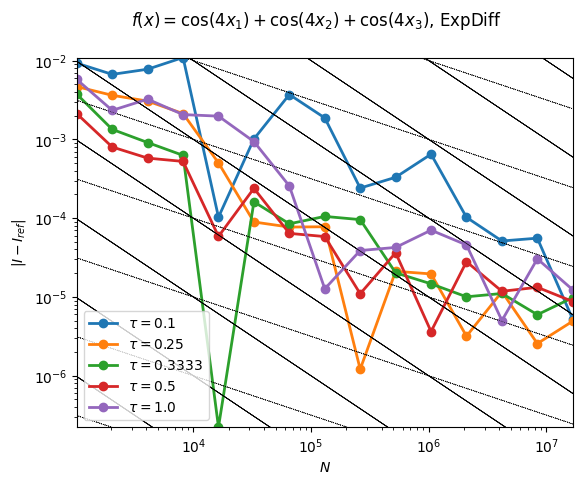

In [43]:
d = 3

τ_list = [0.1, 0.25, 0.3333, 0.5, 1.0]
N_list = round.(Int, exp2.(range(10, 24, length=15)))


f = x -> sum(cos.(4x))
ref = sin(4) / 8

results = []
for τ in τ_list
    r = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)
    push!(results, r)
end

plot_N_convergence(N_list,
                   [r .- ref for r in results],
                   [raw"$\tau = $" * string(τ) for τ in τ_list],
                   "qMC_cos4x_expdiff_tau.pdf",
                   title = raw"$f(x) = \cos(4x_1) + \cos(4x_2) + \cos(4x_3)$, ExpDiff")

## $d=3$, integrand with interpolation

No interpolation.

  3.161609 seconds (33.59 M allocations: 2.502 GiB, 8.55% gc time, 0.72% compilation time)
  3.920634 seconds (33.59 M allocations: 2.502 GiB, 6.74% gc time, 0.59% compilation time)
  3.230173 seconds (33.58 M allocations: 2.502 GiB, 7.50% gc time, 0.67% compilation time)


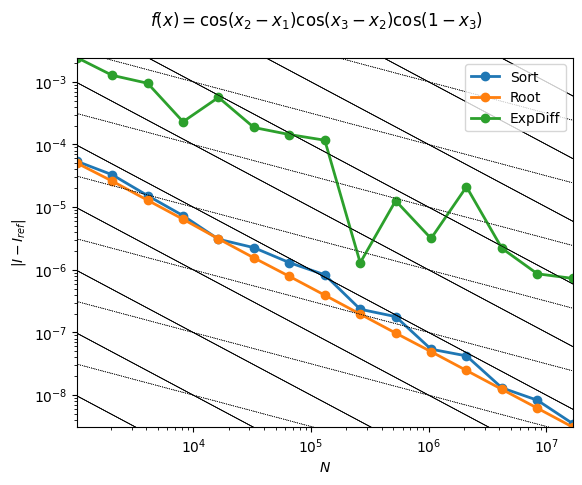

In [44]:
d = 3

τ = 0.25
N_list = round.(Int, exp2.(range(10, 24, length=15)))

# No interpolation
f = x -> cos(x[2] - x[1]) * cos(x[3] - x[2]) * cos(1 - x[3])
ref = (2*sin(1) - cos(1)) / 8

@time results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_list)
@time results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_list)
@time results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff"],
                   "qMC_interp_3d_exact.pdf",
                    title = raw"$f(x) = \cos(x_2-x_1) \cos(x_3-x_2) \cos(1-x_3)$")

Interpolation: 11 knots

  6.857765 seconds (202.00 M allocations: 5.034 GiB, 8.33% gc time, 2.74% compilation time)
  7.585436 seconds (201.37 M allocations: 5.002 GiB, 7.80% gc time, 0.35% compilation time)
  5.994723 seconds (161.42 M allocations: 4.407 GiB, 8.07% gc time, 0.50% compilation time)


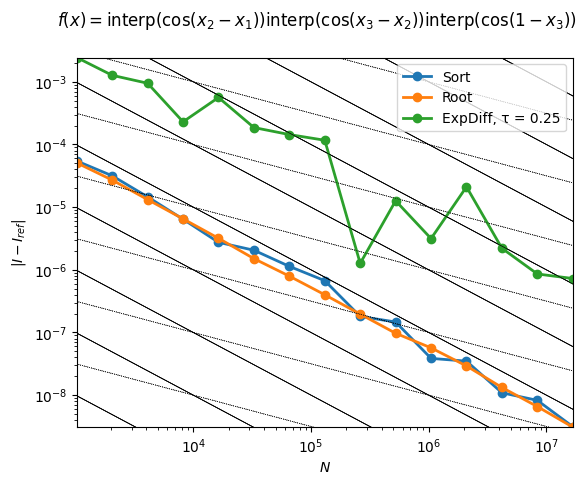

In [45]:
using Interpolations: LinearInterpolation

d = 3

τ = 0.25
N_list = round.(Int, exp2.(range(10, 24, length=15)))

knots = range(0, stop=1.0, length=11)
cos_interp = LinearInterpolation(knots, cos.(knots))
f = x -> cos_interp(x[2] - x[1]) * cos_interp(x[3] - x[2]) * cos_interp(1 - x[3])

ref = 0.14247358769484578 # From Mathematica

@time results_sort = scan_N_range(f, d, sort, u -> simplex_vol(d), N_list)
@time results_root = scan_N_range(f, d, make_trans_root(d), u -> simplex_vol(d), N_list)
@time results_expdiff = scan_N_range(f, d, make_trans_expdiff(d, τ), make_jacobian_expdiff(d, τ), N_list)

plot_N_convergence(N_list,
                   [results_sort .- ref, results_root .- ref, results_expdiff .- ref],
                   ["Sort", "Root", "ExpDiff, τ = $τ"],
                   "qMC_interp_3d_11.pdf",
                   title = raw"$f(x) = \mathrm{interp}(\cos(x_2-x_1)) \mathrm{interp}(\cos(x_3-x_2)) \mathrm{interp}(\cos(1-x_3))$")